# Project 4: Amplitude damping

# Solution

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Main qiskit imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

# Error mitigation
from qiskit_experiments.library.characterization import LocalReadoutError

In [2]:
# Noisy backend
backend = AerSimulator.from_backend(FakePerth())

# Local simulator and vector simulator
simulator = AerSimulator()

## Task 1

In [3]:
def c1(R,t):
    """Returns the coherence factor in the amplitude damping channel
    
    Args:
        R (float): value of R = \gamma_0/\lambda
        t (float): value of the time variable
    
    Returns:
        A float number
    """
    
    if R < 0.5:
        c1 = np.exp(- t / 2.0) * (np.cosh(t * np.sqrt(1.0 - 2.0 * R) / 2.0) + 1.0 / np.sqrt(1.0 - 2.0 * R) * np.sinh(t * np.sqrt(1.0 - 2.0 * R) / 2.0))
    else:
        c1 = np.exp(- t / 2.0) * (np.cos(t * np.sqrt(2.0 * R - 1.0) / 2.0) + 1.0 / np.sqrt(2.0 * R - 1.0) * np.sin(t * np.sqrt(2.0 * R - 1.0) / 2.0))
    
    return c1

### Task 2

In [4]:
def amplitude_damping_channel(q, c, sys, env, R, t):
    """Returns a QuantumCircuit implementing the amplitude damping channel on the system qubit
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system qubit
        sys (int): index for the system qubit
        env (int): index for the environment qubit
        R (float): value of R = \gamma_0/\lambda
        t (float): value of the time variable
    
    Returns:
        A QuantumCircuit object
    """
    ad = QuantumCircuit(q, c)
    
    # Rotation angle
    theta = np.arccos(c1(R, t))
    
    # Channel (notice the extra factor of 2 due to the definition
    # of the unitary gate in qiskit)
    ad.cu(2.0 * theta, 0.0, 0.0, 0.0, q[sys], q[env])
    ad.cx(q[env], q[sys])
    
    # Masurement in the computational basis
    ad.measure(q[sys], c[0])
    
    return ad

# We choose to add the initial condition elsewhere
def initial_state(q, sys):
    """Returns a QuantumCircuit implementing the initial condition for the amplitude damping channel
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        sys (int): index for the system qubit
    
    Returns:
        A QuantumCircuit object
    """
    # Create circuit
    ic = QuantumCircuit(q)
    
    # System in |1>
    ic.x(q[sys])
    
    return ic

### Task 3

In [5]:
SHOTS = 8192

# The values for R and corresponding times
R_values = [0.2, 100.0, 200.0, 400.0]
npoints = 30
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(1, name="c")

## Indices of the system and environment qubits
sys = 1
env = 2

## For values of R and thirty values of t for each
circuits = {}
for R in R_values:
    circuits[R] = []
    for t in t_values[R]:
        circuits[R].append(initial_state(q, sys).compose(
                           amplitude_damping_channel(q, c, sys, env, R, t)))

In [6]:
exp = LocalReadoutError([sys], backend=backend)
res = exp.run(shots=SHOTS)
mitigator = res.analysis_results(0).value

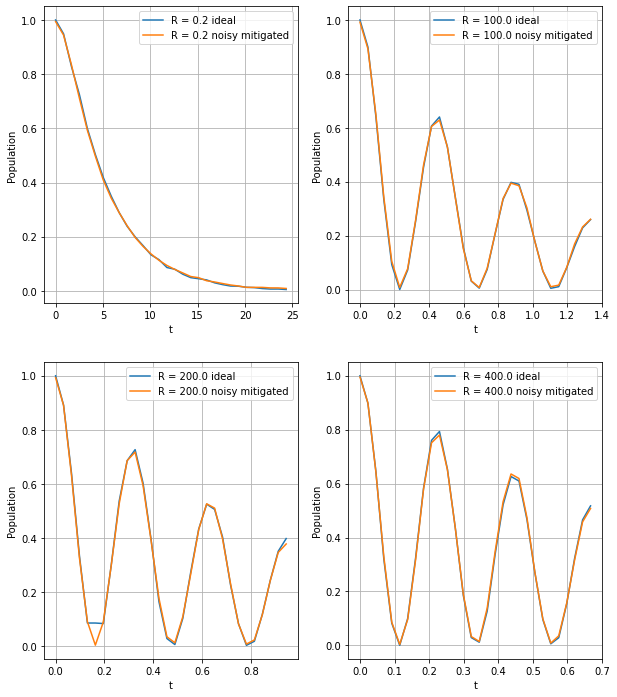

In [7]:
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = simulator.run(circuits[R], shots = SHOTS)

# Analyse the outcomes
populations_sim = {}
for R in R_values:
    populations_sim[R] = []
    current_job_res = jobs_sim[R].result()
    for i in range(npoints):
        counts = current_job_res.get_counts(i)
        if '1' in counts:
            sm = counts['1']/float(SHOTS)
        populations_sim[R].append(sm)

# Execute the circuits on the local simulator
jobs_mit = {}
for R in R_values:
    jobs_mit[R] = backend.run(circuits[R], shots = SHOTS)

# Analyse the outcomes
populations_mit = {}
for R in R_values:
    populations_mit[R] = []
    current_job_res = jobs_mit[R].result()
    for i in range(npoints):
        counts = current_job_res.get_counts(i)
        unmitigated_probs = {label: count / SHOTS for label, count in counts.items()}
        mitigated_quasi_probs = mitigator.quasi_probabilities(unmitigated_probs)
        mitigated_probs = mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities()
        mitigated_probs = {k[::-1]: v for k, v in mitigated_probs.items()}
        if '1' in mitigated_probs:
            sm = mitigated_probs['1']
        populations_mit[R].append(sm)

# Plot the results
# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], populations_sim[R], label=f"R = {R} ideal")
    plt.plot(t_values[R], populations_mit[R], label=f"R = {R} noisy mitigated")
    plt.xlabel('t')
    plt.ylabel('Population')
    plt.legend()
    fig_idx += 1
    plt.grid()

## Task 4

In [8]:
def amplitude_damping_channel_witness(q, c, sys, env, anc, observable, R, t):
    """Returns a QuantumCircuit implementing the amplitude damping channel on the system qubit with non-Markovianity witness
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        c (ClassicalRegister): the register to use for the measurement of the system and ancilla qubits
        sys (int): index for the system qubit
        env (int): index for the environment qubit
        anc (int): index for the ancillary qubit
        observable (str): the observable to be measured
        R (float): value of R = \gamma_0/\lambda
        t (float): value of the time variable
    
    Returns:
        A QuantumCircuit object
    """
    ad = QuantumCircuit(q, c)
    
    # Rotation angle
    theta = 2.0 * np.arccos(c1(R, t))
    
    # Channel
    ad.cu(theta, 0.0, 0.0, 0.0, q[sys], q[env])
    ad.cx(q[env], q[sys])
    
    # Masurement of the corresponding observable
    if observable == 'xx':
        ad.h(sys)
        ad.h(anc)
    elif observable == 'yy':
        ad.sdg(sys)
        ad.h(sys)
        ad.sdg(anc)
        ad.h(anc)
    ad.measure(sys,c[0])
    ad.measure(anc,c[1])
    
    return ad

# We set the initial entangled state separately
def initial_state_witness(q, sys, anc):
    """Returns a QuantumCircuit implementing the initial condition for the amplitude damping channel with non-Markovianity witness
    
    Args:
        q (QuantumRegister): the register to use for the circuit
        sys (int): index for the system qubit
        anc (int): index for the ancilla qubit
    
    Returns:
        A QuantumCircuit object
    """
    # Create circuit
    ic = QuantumCircuit(q)
    
    # System and ancilla in |\psi^+>
    ic.h(q[sys])
    ic.cx(q[sys], q[anc])
    
    return ic

### Task 5

In [9]:
SHOTS = 8192

# The values for R and corresponding times,
# as well as the observables needed for the witness
observables = ['xx', 'yy', 'zz']
R_values = [0.2, 100.0]
npoints = 30
t_values = {}
for R in R_values:
    t_values[R] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)

# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(2, name="c")

## Indices of the system, environment and ancillary qubits
sys = 1
env = 2
anc = 3

## Two values of R and thirty values of t for each
## The witness requires measuring three observables per point
circuits = {}
for R in R_values:
    circuits[R] = {}
    for observable in observables:
        circuits[R][observable] = []
        for t in t_values[R]:
            circuits[R][observable].append(initial_state_witness(q, sys, anc).compose(amplitude_damping_channel_witness(q, c, sys, env, anc, observable, R, t)))

In [10]:
exp = LocalReadoutError([sys, anc], backend=backend)
res = exp.run(shots=SHOTS)
mitigator = res.analysis_results(0).value

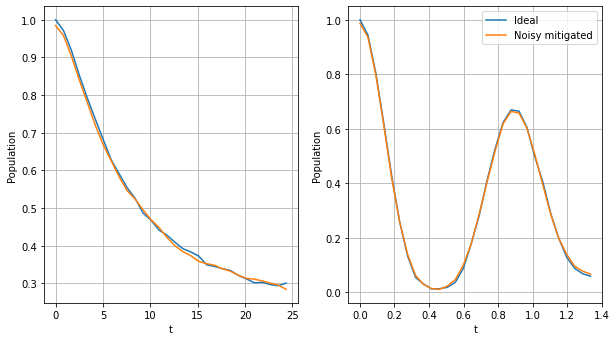

In [11]:
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = {}
    for observable in observables:
        jobs_sim[R][observable] = simulator.run(circuits[R][observable], shots = SHOTS)

# Analyse the outcomes
## Compute expected values
expected_sim = {}
for R in R_values:
    expected_sim[R] = {}
    for observable in observables:
        expected_sim[R][observable] = []
        current_job_res = jobs_sim[R][observable].result()
        for i in range(npoints):
            counts = current_job_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected_sim[R][observable].append(expc)

## Compute witness
witness_sim = {}
for R in R_values:
    witness_sim[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected_sim[R]['xx'][i]-expected_sim[R]['yy'][i]+expected_sim[R]['zz'][i])
        witness_sim[R].append(w)

# Execute the circuits on the local simulator
jobs_mit = {}
for R in R_values:
    jobs_mit[R] = {}
    for observable in observables:
        jobs_mit[R][observable] = backend.run(circuits[R][observable], shots = SHOTS)

# Analyse the outcomes
## Compute expected values
expected_mit = {}
for R in R_values:
    expected_mit[R] = {}
    for observable in observables:
        expected_mit[R][observable] = []
        current_job_res = jobs_mit[R][observable].result()
        for i in range(npoints):
            counts = current_job_res.get_counts(i)
            unmitigated_probs = {label: count / SHOTS for label, count in counts.items()}
            mitigated_quasi_probs = mitigator.quasi_probabilities(unmitigated_probs)
            mitigated_probs = mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities(2)
            mitigated_probs = {k[::-1]: v for k, v in mitigated_probs.items()}
            expc = 0.0
            for outcome in mitigated_probs:
                if outcome[0] == outcome[1]:
                    expc += mitigated_probs[outcome]
                else:
                    expc -= mitigated_probs[outcome]
            expected_mit[R][observable].append(expc)

## Compute witness
witness_mit = {}
for R in R_values:
    witness_mit[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected_mit[R]['xx'][i]-expected_mit[R]['yy'][i]+expected_mit[R]['zz'][i])
        witness_mit[R].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], witness_sim[R], label='Ideal')
    plt.plot(t_values[R], witness_mit[R], label='Noisy mitigated')
    plt.xlabel('t')
    plt.ylabel('Population')
    fig_idx += 1
    plt.grid()
plt.legend()